# Deep Learning Classifier

### Achievement
Using a deep neural network in combination with hyperparameter search, we obtain a binary classifier able to distinguish benign from malicious network traffic with the following performance characteristics:

|PR Score|Precision Positive|Recall Positive|False-Positives|False-Negatives|
|---|---|---|---|---|
|0.97816|0.967|0.954|8966|12629|


## 1. Introduction

In this notebook, we will pursue a supervised learning approach, to create a binary classifier that is able to distinguish benign from malicious network traffic.    
We will train multiple deep neural network models, using the network traffic data taken from the [CIC-IDS-2018 dataset](https://www.unb.ca/cic/datasets/ids-2018.html), and will evaluate their respective performance.    
For this purpose, values of the target variable of the dataset are grouped into two classes,  benign and attack, with the attack class subsuming all types of malicious network traffic. As the dataset is severly imbalanced, containing 83% of benign and only 27% of malicious samples, we will have to take this class imbalance into account during training.

In the first part of the notebook, we train a rather simple deep network, using two different approaches.
The first approach does not take class imbalance into account, while the second approach uses the class weights to weight the losses of the under-represented samples more heavily during training.    
Comparing the results of both training runs, we decide on using one of the two approaches going forward.

In the second part of the notebook, we concern ourselves with finding the optimal model architecture and parameter configuration for the classifier, by employing hyperparameter optimization using the [Hyperopt](https://github.com/hyperopt/hyperopt) library.

The deep learning models are trained using the [Keras](https://keras.io/) library, employing [Tensorflow 2](https://www.tensorflow.org/) as the auto-differentiation framework in the backend.

## 2. Dataset Preparation

In this section we load the dataset and prepare the data for training. The preprocessed dataset from CIC-IDS-2018 can be found at [Google Drive](https://drive.google.com/open?id=1HrTPh0YRSZ4T9DLa_c47lubheKUcPl0r).

In [1]:
dataset_base_path = r'/home/glados/Development/Projects/ids-2018/processed'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gc
import shap
from ml_ids.data.dataset import load_dataset
from ml_ids.data.metadata import FEATURES_NO_VARIANCE
from ml_ids.visualization import plot_hist, print_binary_performance, plot_pr_curve
from ml_ids.keras.metrics import AveragePrecisionScoreMetric
from ml_ids.keras.evaluation import evaluate_model
from ml_ids.keras.prediction import predict, predict_proba
from ml_ids.tf_utils import enable_gpu_memory_growth
from notebook_utils import transform_data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers, metrics
from collections import Counter
from hyperopt import fmin, hp, tpe, atpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid

K = keras.backend

rand_state = 42
tf.random.set_seed(rand_state)
np.random.seed(rand_state)

enable_gpu_memory_growth()

%matplotlib inline

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### 2.1 Data Loading & Preparation

In this part we load the dataset, specifing the features to omit. These encompass all features having no variance and features which should not be taken into account, in order to obtain a better generalization of the model.

We use `median` imputation as the strategy to impute missing values, as the distributions of all features, for which imputation is necessary, are highly skewed. 
Futhermore, we scale the data using a `StandardScaler` and upsample the malicious network traffic to obtain  `100000` samples per attack category. We perform upsampling by using the technique of Synthetic Minority Over-sampling provided by the [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) library.

Furthermore, the dataset is splitted into:
* training set,
* validation set and
* test set.

In [3]:
dataset = load_dataset(dataset_base_path,
                       omit_cols=FEATURES_NO_VARIANCE + ['timestamp', 'dst_port', 'protocol'],
                       preserve_neg_value_cols=['init_fwd_win_byts', 'init_bwd_win_byts'])

X_train, y_train, X_val, y_val, X_test, y_test, column_names = transform_data(dataset=dataset,
                                                                              imputer_strategy='median',
                                                                              scaler=StandardScaler,
                                                                              attack_samples=100000,
                                                                              random_state=rand_state)

del dataset

Samples:
Training: (12986354, 68)
Val:      (1623294, 68)
Test:     (1623295, 68)

Training labels:
Benign                      10787766
DDOS attack-HOIC              548809
DDoS attacks-LOIC-HTTP        460953
DoS attacks-Hulk              369530
Bot                           228953
FTP-BruteForce                154688
SSH-Bruteforce                150071
Infilteration                 129547
DoS attacks-SlowHTTPTest      111912
DoS attacks-GoldenEye          33206
DoS attacks-Slowloris           8792
DDOS attack-LOIC-UDP            1384
Brute Force -Web                 489
Brute Force -XSS                 184
SQL Injection                     70
Name: label, dtype: int64

Validation labels:
Benign                      1348471
DDOS attack-HOIC              68601
DDoS attacks-LOIC-HTTP        57619
DoS attacks-Hulk              46191
Bot                           28619
FTP-BruteForce                19336
SSH-Bruteforce                18759
Infilteration                 16193
DoS attacks

### 2.2 Target Grouping & Class Weight Calculation

In this step we create the binary target variable by grouping all malicious network traffic into a single attack category represented by the positive class `1`, whereas benign traffic is represented as the negative class `0`.

Furthermore, we calculate the weights for each class, given by the proportion of samples of this class in the training set.   
For the majority class, the class weight is `1`.   
For the minority class, the class weight is calculated with the following formula:
\begin{align}
\frac{(sum\_majority\_class)}{(sum\_minority\_class)} \\
\end{align}
In our case this translates to:
\begin{align}
\frac{(sum\_negative\_class)}{(sum\_positive\_class)} \\
\end{align}

In [4]:
y_train_is_attack = (y_train != 0).astype('int')

minority_class_weight = len(y_train_is_attack[y_train_is_attack == 0]) / len(y_train_is_attack[y_train_is_attack == 1])

class_weights = { 
    0: 1, 
    1: minority_class_weight
}

## 3. Static Model Training

In this section, we train a static model, comprised of `3` layers, each containing `400` units, using the `Adam` optimizer.    
We execute two training runs. In run one we ignore the class imbalance, whereas in run two we use the class weights to take the class imblance into account.    
Afterwards we compare the results and select one approach to use for hyperparameter optimization.

In [5]:
def create_model(input_dims, 
                 nr_layers, 
                 nr_units, 
                 activation, 
                 kerner_initializer,
                 optimizer,
                 dropout_layer=None):
    model = models.Sequential()
    model.add(layers.Input(shape=[input_dims]))
    
    for l in range(nr_layers):
        model.add(layers.Dense(nr_units, activation=activation, kernel_initializer=kerner_initializer))
        
    if dropout_layer:
        model.add(dropout_layer)
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=[metrics.AUC(curve='PR'),
                           metrics.Precision(), 
                           metrics.Recall()])
    return model

In [6]:
def train_static_model(X_train, y_train, X_val, y_val, model_path, class_weights=None):    
    input_dims = X_train.shape[1]
    epochs = 20
    batch_size = 4096
    
    K.clear_session()
    gc.collect()

    model = create_model(input_dims=input_dims,
                         nr_layers=3,
                         nr_units=400,
                         activation='selu',
                         kerner_initializer='lecun_normal',
                         optimizer=optimizers.Adam())

    print(model.summary())
    
    mc = callbacks.ModelCheckpoint(filepath=model_path, save_best_only=True)

    lr_scheduler = callbacks.ReduceLROnPlateau(factor=0.2, patience=3)

    hist = model.fit(x=X_train, 
                     y=y_train,
                     validation_data=(X_val, y_val),
                     batch_size=batch_size,
                     epochs=epochs,
                     class_weight=class_weights,
                     callbacks=[
                         lr_scheduler,
                         mc
                     ])
    
    return model, hist

### 3.1 Static Model without class weights

In this step, we train the static model withouth using class weights.

In [ ]:
model_no_class_weights, hist = train_static_model(X_train, 
                                                  y_train_is_attack, 
                                                  X_val, 
                                                  y_val.label_is_attack.values,
                                                  'models/model_no_class_weights.h5')

[Output omitted for brevity]

### Validation

Inspecting the metrics and learning curves, we observe that the model does not overfit the training set.

In [269]:
model_no_class_weights = models.load_model('models/model_no_class_weights.h5')
evaluate_model(model_no_class_weights, 
               X_train, 
               y_train_is_attack,
               X_val, y_val.label_is_attack.values, 
               metric_title='Loss / PR AUC / Precision / Recall')

Evaluation:
       Loss / PR AUC / Precision / Recall
Train: [0.04862239808849553, 0.98295105, 0.99410915, 0.94906664]
Val:   [0.048875621330395747, 0.97678155, 0.9924735, 0.93851316]


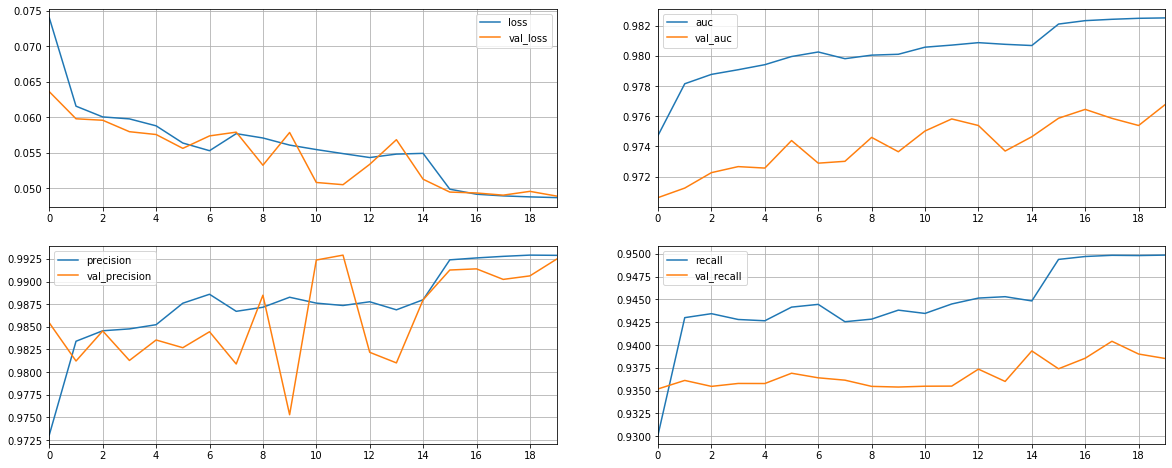

In [270]:
fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))

plot_hist(hist, ax=ax1)
plot_hist(hist, metrics=['auc', 'val_auc'], ax=ax2)
plot_hist(hist, metrics=['precision', 'val_precision'], ax=ax3)
plot_hist(hist, metrics=['recall', 'val_recall'], ax=ax4)

### Performance

The performance of the model is quite compelling with a PR score of `0.97718`.    
Looking at the classification report we notice that the precision of the positive class is quite high (`0.992`), while having a lower recall (`0.939`). This effect is most likely caused by the overwhelming amount of samples from the negative class in the training set.    
Consequently, the confusion matrix reveals a low amount of false-positives (`1956` samples) but a high amount of false-negatives (`16898` samples).    
The misclassification statistic shows that the majority of false-negative results originate from the attack category of `Infiltration`, with a misclassification rate of `98%`.

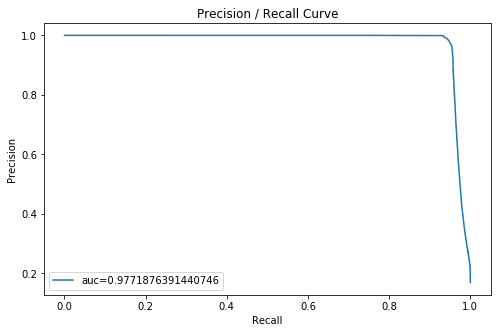

Average PR Score 0.9771876391440746


In [272]:
pred_val_score = predict_proba(model_no_class_weights, X_val)
plot_pr_curve(y_val.label_is_attack.values, pred_val_score)

Classification Report:
              precision    recall  f1-score   support

           0      0.988     0.999     0.993   1348471
           1      0.992     0.939     0.965    274823

    accuracy                          0.988   1623294
   macro avg      0.990     0.969     0.979   1623294
weighted avg      0.988     0.988     0.988   1623294

Confusion Matrix:


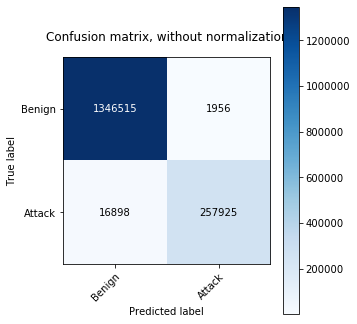

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,15884,16193,0.980918
SQL Injection,2,9,0.222222
Brute Force -Web,3,61,0.049180
Brute Force -XSS,1,23,0.043478
Bot,905,28619,0.031622
DoS attacks-Slowloris,6,1099,0.005460
DDoS attacks-LOIC-HTTP,87,57619,0.001510
Benign,1956,1348471,0.001451
DDOS attack-HOIC,8,68601,0.000117
SSH-Bruteforce,2,18759,0.000107


In [289]:
pred_val = predict(model_no_class_weights, X_val)
print_binary_performance(y_val, y_val.label_is_attack, pred_val)

### 3.2 Static Model using class weights

In this step, we train the static model using class weights to take the class imbalance into account.

In [ ]:
model_class_weights, hist = train_static_model(X_train, 
                                               y_train_is_attack, 
                                               X_val, 
                                               y_val.label_is_attack.values,
                                               'models/model_class_weight.h5',
                                               class_weights)

[Output omitted for brevity]

### Validation

Inspecting the metrics and learning curves, we observe that the model does not significantly overfit the training set.

In [169]:
model_class_weights = models.load_model('models/model_class_weight.h5')
evaluate_model(model_class_weights, 
               X_train, 
               y_train_is_attack, 
               X_val, 
               y_val.label_is_attack.values,
               metric_title='Loss / PR AUC / Precision / Recall')

Evaluation:
       Loss / PR AUC / Precision / Recall
Train: [0.06124674869864, 0.9829123, 0.97260857, 0.96141064]
Val:   [0.06319707397520061, 0.9765367, 0.96547586, 0.953974]


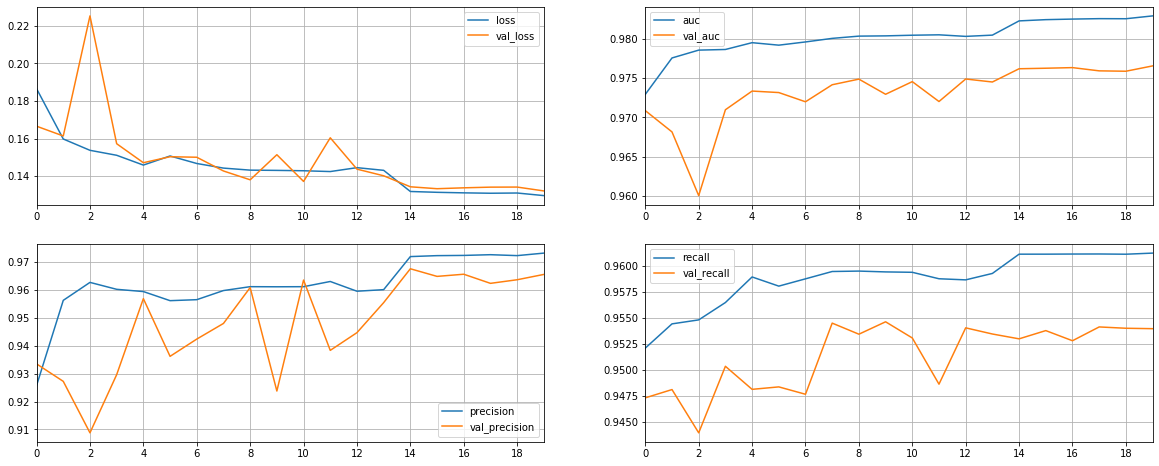

In [168]:
fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))

plot_hist(hist, ax=ax1)
plot_hist(hist, metrics=['auc', 'val_auc'], ax=ax2)
plot_hist(hist, metrics=['precision', 'val_precision'], ax=ax3)
plot_hist(hist, metrics=['recall', 'val_recall'], ax=ax4)

### Performance

The performance of the model in terms of the PR score is only marginally better than the previous model with a score of `0.97735`.   
However, the classification report shows a different combination of precision and recall for the positive class, with a precision of `0.965` and recall of `0.954`.   
The confusion matrix reveals a nearly equal amount of false-positives (`9375` samples) and false-negatives (`12649` samples).  
Even though the misclassification rate of `Infiltration` was reduced to `77%`, it still is very high.

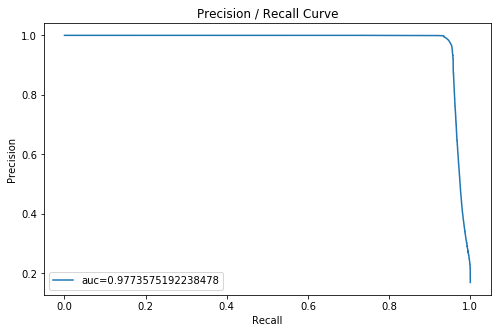

Average PR Score 0.9773575192238478


In [190]:
pred_val_score = predict_proba(model_class_weights, X_val)
plot_pr_curve(y_val.label_is_attack.values, pred_val_score)

Classification Report:
              precision    recall  f1-score   support

           0      0.991     0.993     0.992   1348471
           1      0.965     0.954     0.960    274823

    accuracy                          0.986   1623294
   macro avg      0.978     0.974     0.976   1623294
weighted avg      0.986     0.986     0.986   1623294

Confusion Matrix:


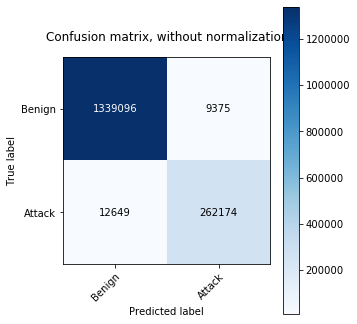

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,12538,16193,0.774285
SQL Injection,2,9,0.222222
Brute Force -Web,3,61,0.049180
Brute Force -XSS,1,23,0.043478
Benign,9375,1348471,0.006952
DoS attacks-Slowloris,6,1099,0.005460
Bot,47,28619,0.001642
DDoS attacks-LOIC-HTTP,50,57619,0.000868
SSH-Bruteforce,2,18759,0.000107


In [290]:
pred_val = predict(model_class_weights, X_val)
print_binary_performance(y_val, y_val.label_is_attack, pred_val)

### 3.3 Model Comparison

|Model|PR Score|Precision Positive|Recall Positive|False-Positives|False-Negatives|
|---|---|---|---|---|---|
|No class-weights|0.97718|0.992|**0.939**|1956|**16898**|
|Class-weights|0.97735|0.965|**0.954**|9375|**12649**|

Using the class weights during training, we obtain a reduction in precision of `~2.7%` but an increase in recall of `~1.6%`.    
Consequently, the number of false-negatives are reduced, while the number of false-positives are increased by an acceptable amount.    
As the primary goal of our classifier is to detect as many attacks as possible, we choose to continue using the second approach, applying the class weights during training.

Both models suffer from a high misclassification rate in regards to the attack category of `Infiltration`, most likely due to the fact that benign traffic and infiltration traffic is very similar.

## 4. Model Training with Hyperparameter Optimization

In this section we will use the [Hyperopt](https://github.com/hyperopt/hyperopt) library to train and evaluate various model architectures in combination with different hyperparameter configurations. For this purpose, we define a training method that accepts the model parameters from the Hyperopt library, dynamically creating the model, performing training and returning the lowest validation loss.

In [26]:
def train_dynamic_model(args):
    print('\nRun') 
    print('==========')
    print('Parameters:\n{}'.format(args))
    
    epochs = int(args['epochs'])
    batch_size = int(args['batch_size'])
    nr_layers = int(args['nr_layers'])
    nr_units = int(args['nr_units'])
    activation = args['activation']
    dropout_rate = args['dropout_rate']
    model_name = 'models/{}.h5'.format(uuid.uuid4())
    
    if activation == 'elu':
        kerner_initializer = 'he_normal'
        dropout_layer = layers.Dropout(dropout_rate)
    elif activation == 'selu':
        kerner_initializer = 'lecun_normal'
        dropout_layer = layers.AlphaDropout(dropout_rate)
    else:
        raise ValueError('Invalid activation "{}" supplied.'.format(opt_args['name']))
    
    opt_name = args['optimizer']['name']
    opt_lr_mult = args['optimizer']['lr_mult']
    
    if opt_name == 'sgd':
        optimizer = optimizers.SGD(lr=(0.01 * opt_lr_mult), momentum=0.9, nesterov=True)
    elif opt_name == 'adam':
        optimizer = optimizers.Adam(lr=(0.001 * opt_lr_mult))
    elif opt_name == 'nadam':
        optimizer = optimizers.Nadam(lr=(0.002 * opt_lr_mult))
    else:
        raise ValueError('Invalid optimizer "{}" supplied.'.format(opt_args['name']))
        
    K.clear_session()
    gc.collect()
    
    model = create_model(input_dims=X_train.shape[1], 
                         nr_layers=nr_layers, 
                         nr_units=nr_units, 
                         activation=activation, 
                         kerner_initializer=kerner_initializer,
                         optimizer=optimizer,
                         dropout_layer=dropout_layer)
    
    mc = callbacks.ModelCheckpoint(filepath=model_name, save_best_only=True, verbose=0)
    
    lr_scheduler = callbacks.ReduceLROnPlateau(factor=0.2, patience=5)
    
    hist = model.fit(x=X_train, 
                     y=y_train_is_attack, 
                     validation_data=(X_val, y_val.label_is_attack.values),
                     batch_size=batch_size,
                     epochs=epochs,
                     class_weight=class_weights,
                     callbacks=[
                         lr_scheduler,
                         mc
                     ],
                     verbose=2)
    
    best_loss = np.amin(hist.history['val_loss']) 
    print('Best loss: {}'.format(best_loss))
    print('Model: {}'.format(model_name))
    
    return {
        'loss': best_loss,
        'status': STATUS_OK,
        'model_name': model_name
    }

### 4.1 Search-Space Definition and Training

In order to try a variety of different model architectures and hyperparameters, we have to define the search spaces for each of our parameters. These search spaces will be used to choose values for the corresponding parameters.    
The following search spaces are utilized:
* Number of layers: uniform integer space in the interval of `[2, 6]`.
* Number of units: uniform integer space in the interval of `[100, 1000]` with step size `100`.
* Activation function: choice of `elu` and `selu` activation functions.
* Dropout rate: uniform space in the interval of `[0, 0.5]`.
* Optimizer: choice of `SGD`, `Adam` or `Nadam`.
* Learning rate multiplier: log-uniform space in the interval of `[-0.5, 1]`. This value is used to multiply the default learning rate of the chosen optimizer.

Training is performed on `50` models, with `30` epochs per model and a rather large batch-size of `4096`, which is chosen to keep the training time per model reasonable.

We use the [Tree of Parzen Estimators (TPE)](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf) search algorithm, provided by Hyperopt, to optimize the search process. 

In [ ]:
trials = Trials()

space = { 
    'epochs': hp.choice('epochs', [30]),  
    'batch_size': hp.choice('batch_size', [4096]),
    'nr_layers': hp.quniform('nr_layers', 2, 6, 1),  
    'nr_units': hp.quniform('nr_units', 100, 1000, 100), 
    'activation': hp.choice('activation', ['elu', 'selu']),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
    'optimizer': hp.choice('optimizer', [
        {
            'name': 'sgd',
            'lr_mult': hp.loguniform('sgd_lr_rate_mult', -0.5, 1),
        }, 
        {
            'name': 'adam',
            'lr_mult': hp.loguniform('adam_lr_rate_mult', -0.5, 1),
        },
        {
            'name': 'nadam',
            'lr_mult': hp.loguniform('nadam_lr_rate_mult', -0.5, 1),
        }
    ])
}


best_run = fmin(fn=train_dynamic_model,
                space=space,
                algo=tpe.suggest,
                max_evals=50,
                trials=trials)

[Output omitted for brevity]

### Training Results

After completion of the hyperparameter search process, we plot the chosen parameter spaces. The selected values of the ten best performing models are colorized.      
From the graphs we can infer the following optimal parameter spaces:
* Number of layers: the optimal number of layers seems to be in the interval of `[4, 6]`.
* Number of units: the optimal number of units per layer seems to be in the interval of `[300, 400]`.
* Activation function: the activation function `elu` should be preferred, as it was used for all of the best ten models.
* Dropout rate: a dropout rate `<0.3` seems to perform the best.
* Optimizer: the `Adam` optimizer was used for all of the ten best performing models.
* Learning rate multiplier: the learning rate multiplier seems to perform best if kept `<1.1`.

avg best error: 0.13028952267457333


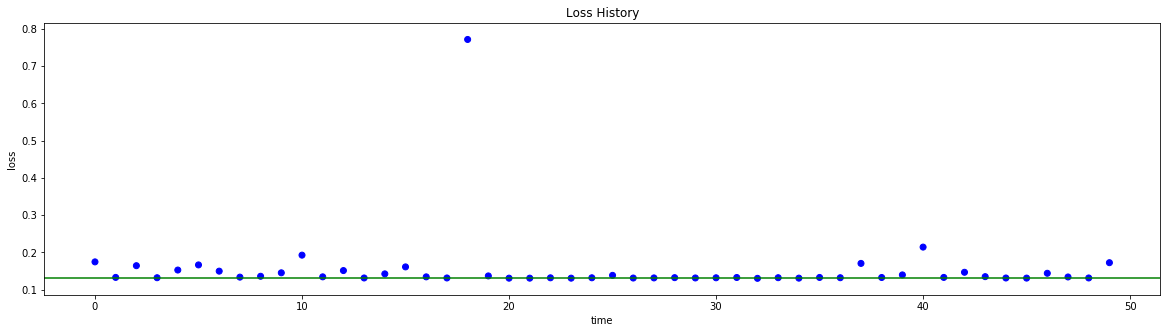

finite loss range 0.13028952267457333 0.7716237019156418 0.13131302273812773


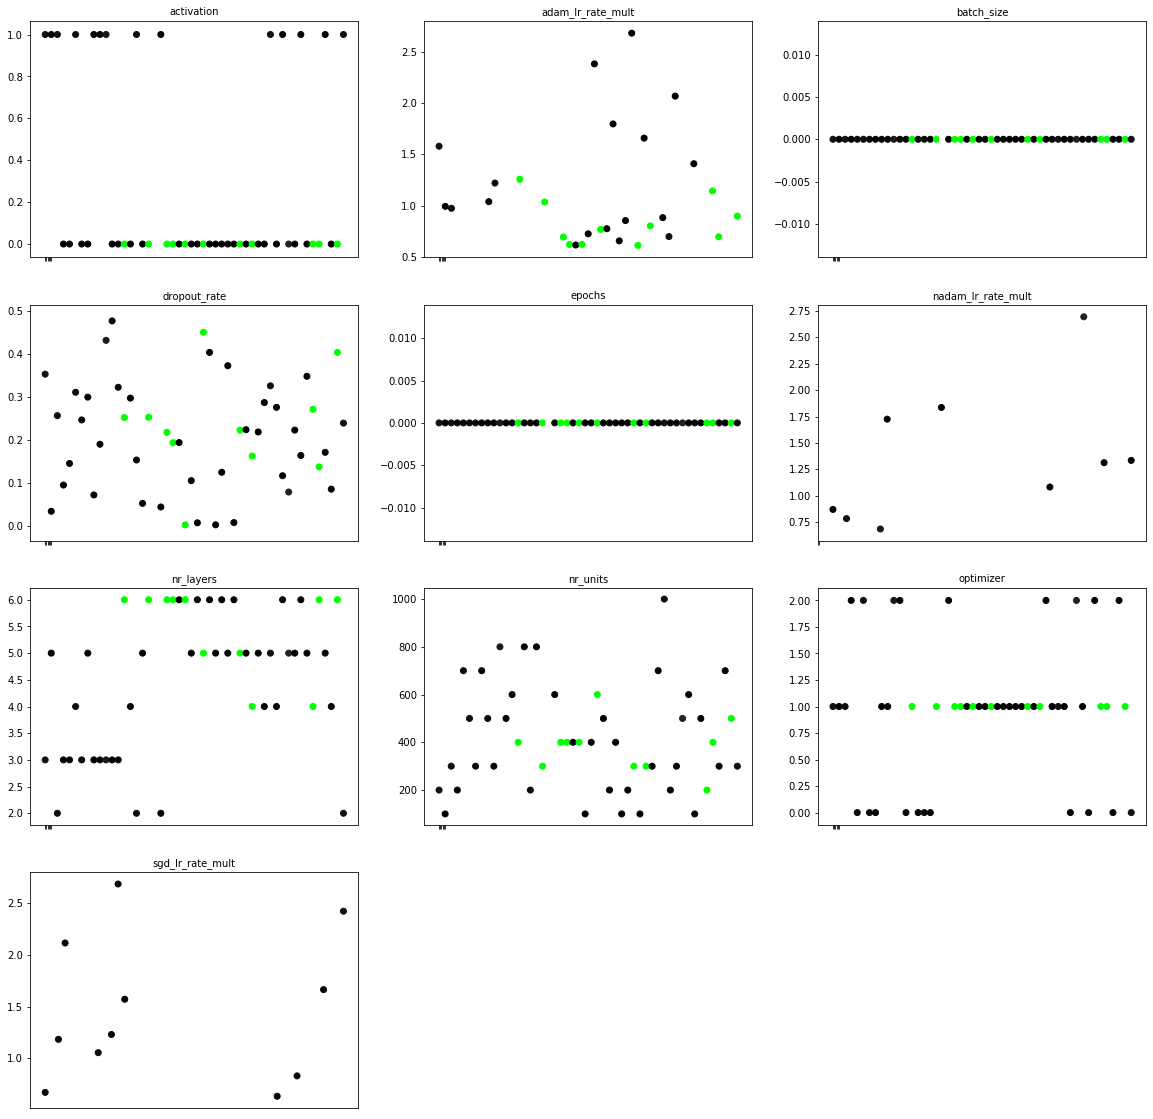

In [249]:
plt.figure(figsize=(20, 5))
main_plot_history(trials)

plt.figure(figsize=(20, 20))
main_plot_vars(trials, columns=3, colorize_best=10, arrange_by_loss=False)

### Best Model Parameters

The best model has the following parameter configuration:
* `5` layers,
* `300` units per layer,
* a dropout rate of `0.22`,
* `elu` activation function,
* `Adam` optimizer,
* learning rate multiplier of `0.61` effectively reducing the default learning rate of `0.001` to `0.00061`.

In [288]:
print('Best validation loss: {}\n'.format(np.min(trials.losses())))
print('Best model parameters:')
print('======================')
best_run

Best validation loss: 0.13028952267457333

Best model parameters:


{'activation': 0,
 'adam_lr_rate_mult': 0.61157158868869,
 'batch_size': 0,
 'dropout_rate': 0.22339774943469998,
 'epochs': 0,
 'nr_layers': 5.0,
 'nr_units': 300.0,
 'optimizer': 1}

In [263]:
best_model_path = trials.results[np.argmin(trials.losses())]['model_name']
print('Best model path: "{}"'.format(best_model_path))
best_model = models.load_model(best_model_path)

Best model path: "models/c0cb0656-558f-4311-b138-9b91ab4d1fe6.h5"


### Performance

The optimized model has an insignificantly higher PR score of `0.97793` compared to the static model with a score of `0.97735`.    

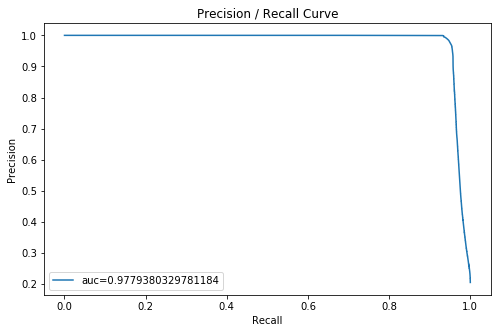

Average PR Score 0.9779380329781184


In [264]:
pred_val_score = predict_proba(best_model, X_val)
plot_pr_curve(y_val.label_is_attack.values, pred_val_score)

### 4.2 Search-Space restriction and Training

As a second optimization step, we use the optimal parameter values discovered in the first round of hyperparameter search, to conduct another round of hyperparameter search on a restricted search space. This allows us to further explore the optimal parameter space.    
For this round of hyperparameter optimization we use a variable batch size and conduct `20` trials.

In [ ]:
trials = Trials()

space = { 
    'epochs': hp.choice('epochs', [30]),  
    'batch_size': hp.quniform('batch_size', 512, 4096, 10),
    'nr_layers': hp.quniform('nr_layers', 4, 6, 1),  
    'nr_units': hp.quniform('nr_units', 300, 400, 100), 
    'activation': hp.choice('activation', ['elu']),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.3),
    'optimizer': hp.choice('optimizer', [
        {
            'name': 'adam',
            'lr_mult': hp.loguniform('adam_lr_rate_mult', -0.5, 1),
        }
    ])
}


best_run = fmin(fn=train_dynamic_model,
                space=space,
                algo=tpe.suggest,
                max_evals=20,
                trials=trials)

[Output omitted for brevity]

Unfortunately, the second round of hyperparameter search did not yield a better result, as the loss of the best model is recorded with `0.1306`, compared to the loss of `0.1302` obtained from the best model of the first round.    
The difference in the losses is negligible though, suggesting that we have found a good configuration for our model.

avg best error: 0.13063318593310846


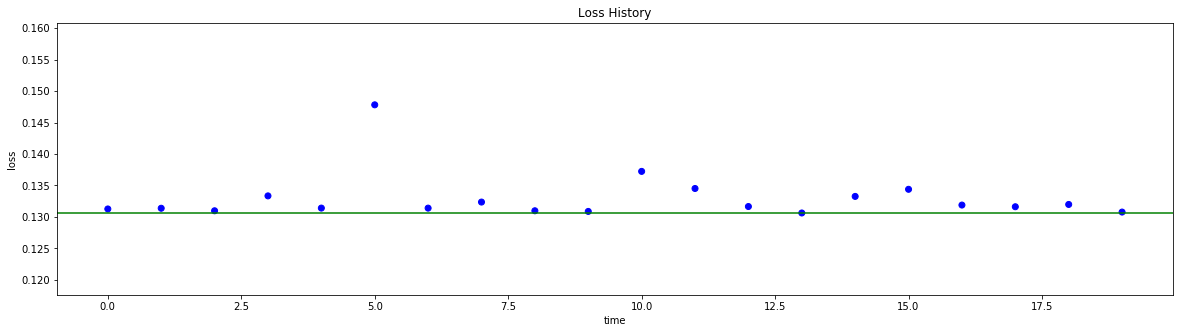

finite loss range 0.13063318593310846 0.14781879949703883 0.1318917911982782


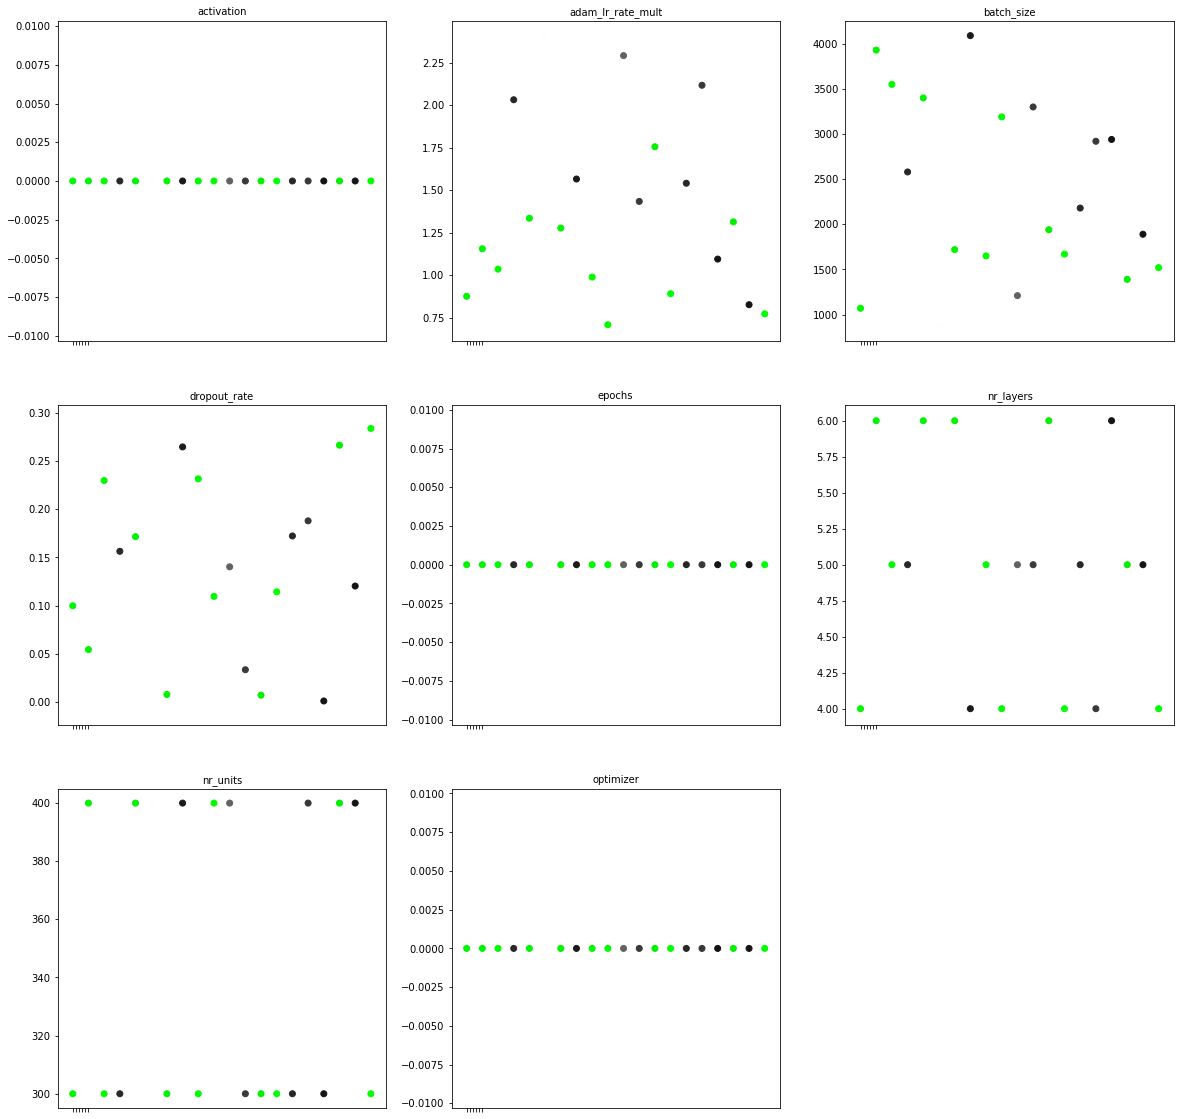

In [32]:
plt.figure(figsize=(20, 5))
main_plot_history(trials)

plt.figure(figsize=(20, 20))
main_plot_vars(trials, columns=3, colorize_best=10, arrange_by_loss=False)

### 4.3 Training a Model with Optimal Parameters

In the last step of this section, we will use the optimal parameter values and model configuration, determined during the first round of hyperparameter search. We train a model using the optimal parameters for `200` epochs, with the objective of obtaining a better performance.    

In [30]:
def train_optimized_model(X_train, y_train, X_val, y_val, model_path, epochs, batch_size, class_weights):    
    input_dims = X_train.shape[1]

    K.clear_session()
    gc.collect()
    
    nr_layers = 5
    nr_units = 300
    dropout_rate = 0.22339774943469998
    lr = (0.001 * 0.61157158868869)

    model = create_model(input_dims=input_dims,
                         nr_layers=nr_layers,
                         nr_units=nr_units,
                         activation='elu',
                         kerner_initializer='he_normal',
                         dropout_layer=layers.Dropout(dropout_rate),
                         optimizer=optimizers.Adam(lr=lr))

    print(model.summary())
    
    mc = callbacks.ModelCheckpoint(filepath=model_path, save_best_only=True)
    
    early_stopping = callbacks.EarlyStopping(patience=50)

    lr_scheduler = callbacks.ReduceLROnPlateau(factor=0.2, patience=5)
    
    hist = model.fit(x=X_train, 
                     y=y_train,
                     validation_data=(X_val, y_val),
                     batch_size=batch_size,
                     epochs=epochs,
                     class_weight=class_weights,
                     callbacks=[mc, lr_scheduler])
    
    return model, hist

In [ ]:
opt_model, hist = train_optimized_model(X_train, 
                                        y_train_is_attack, 
                                        X_val, 
                                        y_val.label_is_attack.values,
                                        'models/opt_model.h5',
                                        epochs=200,
                                        batch_size=4096,
                                        class_weights=class_weights)

[Output omitted for brevity]

### Validation

Inspecting the learning curves, we observe that the model does not significantly overfit the training set.

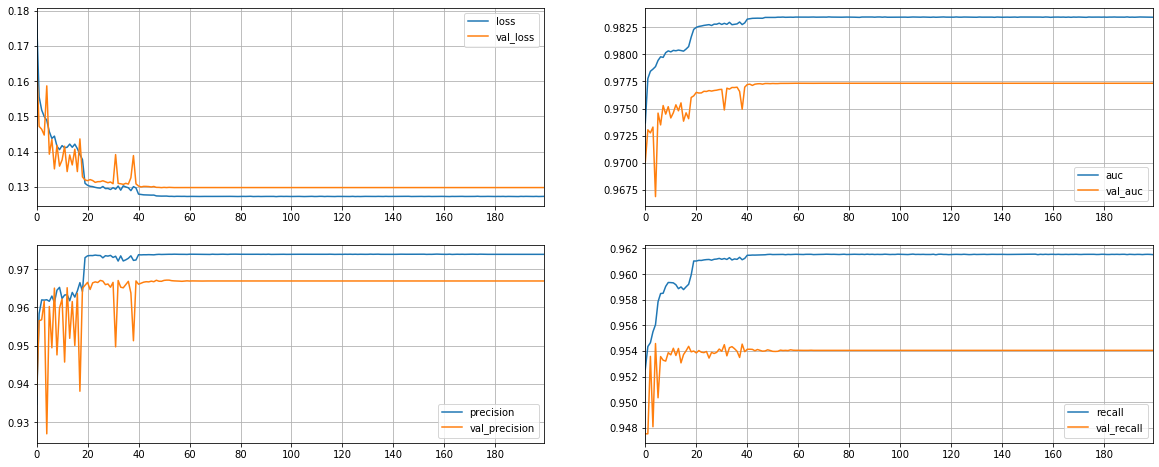

In [34]:
fix, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))

plot_hist(hist, ax=ax1)
plot_hist(hist, metrics=['auc', 'val_auc'], ax=ax2)
plot_hist(hist, metrics=['precision', 'val_precision'], ax=ax3)
plot_hist(hist, metrics=['recall', 'val_recall'], ax=ax4)

### Performance

After training, we obtain a model with a slightly lower loss of `0.1298` and a better PR score of `0.97816` compared to the best model found during hyperparameter search, with a loss of `0.1302` and a PR score of `0.97793`.

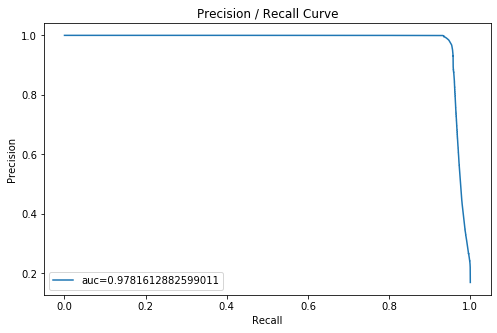

Average PR Score 0.9781612882599011


In [4]:
opt_model = models.load_model('models/opt_model.h5')
pred_val_score = predict_proba(opt_model, X_val)
plot_pr_curve(y_val.label_is_attack.values, pred_val_score)

Classification Report:
              precision    recall  f1-score   support

           0      0.991     0.993     0.992   1348471
           1      0.967     0.954     0.960    274823

    accuracy                          0.987   1623294
   macro avg      0.979     0.974     0.976   1623294
weighted avg      0.987     0.987     0.987   1623294

Confusion Matrix:


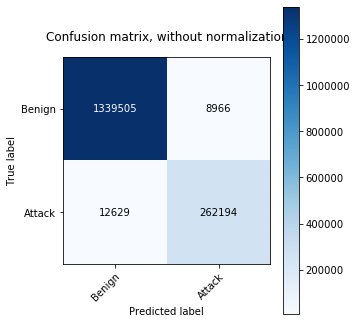

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,12466,16193,0.769839
SQL Injection,2,9,0.222222
Brute Force -Web,3,61,0.049180
Brute Force -XSS,1,23,0.043478
Benign,8966,1348471,0.006649
DoS attacks-Slowloris,6,1099,0.005460
Bot,104,28619,0.003634
DDoS attacks-LOIC-HTTP,45,57619,0.000781
SSH-Bruteforce,2,18759,0.000107


In [5]:
pred_val = predict(opt_model, X_val)
print_binary_performance(y_val, y_val.label_is_attack, pred_val)

## 5. Model Comparison

The model obtained during hyperparameter optimization has a higher PR score of `0.97816` compared to the static model, having a score of `0.97735`.    
Precision and recall are very similar, with values of `0.967` for precision and `0.954` for recall. 
However, both the number of false-positives and the number of false-negatives are lower for the optimized model, as illustrated in the following table:  

|Model|PR Score|Precision Positive|Recall Positive|False-Positives|False-Negatives|
|---|---|---|---|---|---|
|Static model (no class-weights)|0.97718|**0.992**|0.939|**1956**|16898|
|Static model (class-weights)|0.97735|0.965|0.954|9375|12649|
|Optimized model (class-weights)|**0.97816**|0.967|**0.954**|8966|**12629**|

Given the superior performance of the optimized model, we choose to use the this model going forward.

## 6. Conclusion

In this notebook, we explored two approaches of training a deep neural network for the task of binary classification of network traffic, concluding that training should be performed taking class imbalance into account, in order to minimize the amount of false-negatives.    
Furthermore, we conducted hyperparameter search and optimization to explore the optimal network architecture and parameter configuration, resulting in a model with compelling performance.    
Even though the model seems to work well on most types of network attacks, it fails to correctly identify infiltration attacks, misclassifiying `77%` of all infiltration traffic as benign traffic. This could be explained by the simmilarity of feature statistics observed in these two kinds of network traffic.    
As a result, other approaches to reliably detect infiltration attacks have to be explored.